In [14]:
# подключим модули

import pandas as pd
# import numpy as np
# import time
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.downloader.download('vader_lexicon')
# import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import category_encoders as ce

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split  # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

In [15]:
train_data = pd.read_csv('/content/drive/MyDrive/Project/hotels_train.csv') # датасет для обучения
test_data = pd.read_csv('/content/drive/MyDrive/Project/hotels_test.csv') # датасет для предсказания

In [16]:
train_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [17]:
test_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [18]:
# найдем дубликаты
mask = train_data.duplicated(subset=train_data.columns)
data_duplicates = train_data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [19]:
# удалим дубликаты
train_data.drop_duplicates(inplace=True)

In [20]:
# объединим данные
train_data['sample'] = 1
train_data['id'] = train_data.index
test_data['sample'] = 0
test_data['reviewer_score'] = 0
test_data['id'] = test_data.index
data = train_data.copy()
data = pd.concat([train_data,test_data],axis=0,ignore_index=True)

In [21]:
# исследуем данные на наличие пропусков
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

lat    0.634032
lng    0.634032
dtype: float64

In [22]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

In [24]:
# выделим признаки месяца и года из даты отзыва, предварительно приведя признак к формату datetime. 
# Удалим первоначальный признак даты.
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_year'] = data['review_date'].dt.year.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)

data.drop(['review_date', 'positive_review', 'negative_review'], axis=1, inplace=True)

In [15]:
# преобразуем колонку 'tags' таким образом, чтобы остались только 10 наиболее популярных тэгов в значениях.
data['tags'] = data['tags'].apply(lambda x: x.lower())
data['tags_list'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

# Получаем топ-10 тегов
top_tags = list(data['tags'].explode().value_counts().index)[:10]

# Реализуем вариант OneHotEncoder для топ-10 тегов
for t in top_tags:
    data[t] = data['tags'].apply(lambda x: 1 if t in x else 0)

data = data.drop(['tags'], axis=1)

In [25]:
# произведем кодировку признака 'reviewer_nationality' методом двоичного кодирования 
# (так как количество значений более 200). Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['reviewer_nationality'], axis=1, inplace=True)

In [26]:
# gроизведем кодировку признака hotel_name методом двоичного кодирования 
# (так как количество значений более 1400). Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_name'], axis=1, inplace=True)

In [27]:
# удалим оставшиеся текстовые признаки

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [28]:
train_data = data[data['sample'] == 1]
test_data = data[data['sample'] == 0]
train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)

<ipython-input-28-93113067ceb9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['sample','id'],axis=1,inplace=True)
<ipython-input-28-93113067ceb9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)


In [29]:
# непрерывные признаки

num_cols = ['average_score', 'sentiment_score', 'polarity_pos', 'polarity_neg', 
            'total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring', 'days_since_review_int', 
            'сity_population', 'сity_area']

# категориальные признаки
cat_cols = ['review_day', 'review_month', 'review_year', 'review_weekday']   #'tags'

<Axes: >

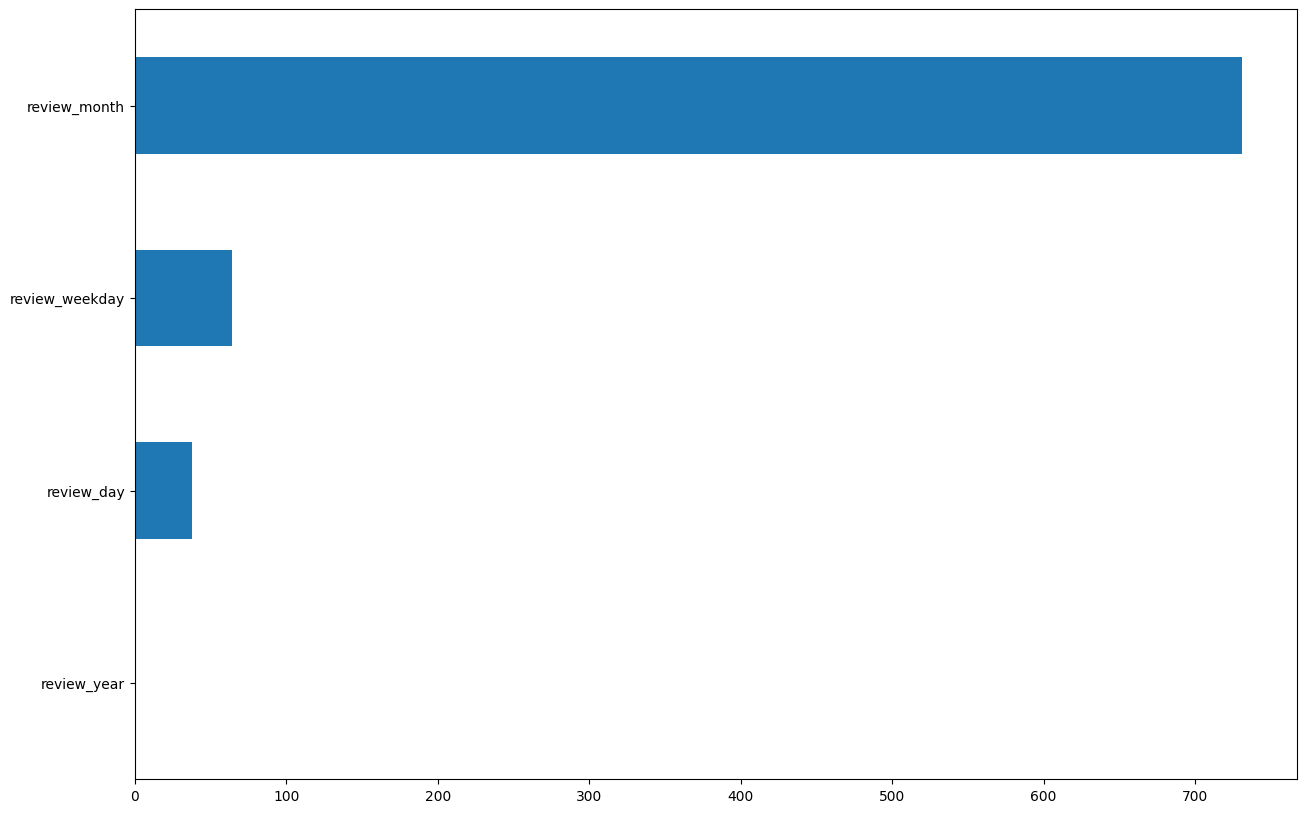

In [30]:
# оценим влияние категориальных признаков

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

y=y.astype('int')

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [31]:
# удалим колонки с низким рейтингом

train_data.drop(['review_year'],axis=1, inplace=True)
test_data.drop(['review_year'],axis=1, inplace=True)

<ipython-input-31-3dd0dae584ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['review_year'],axis=1, inplace=True)
<ipython-input-31-3dd0dae584ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['review_year'],axis=1, inplace=True)


In [ ]:
# pазбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

# наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# создаём модель

RANDOM_SEED = 42
model = RandomForestRegressor(n_estimators=500, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)  
      
# Обучаем модель на тестовом наборе данных

model.fit(X_train, y_train)  
      
# используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  

y_pred = model.predict(X_test)


# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются.  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную
# ошибку предсказанных значений от фактических. 

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.9min


<AxesSubplot: >

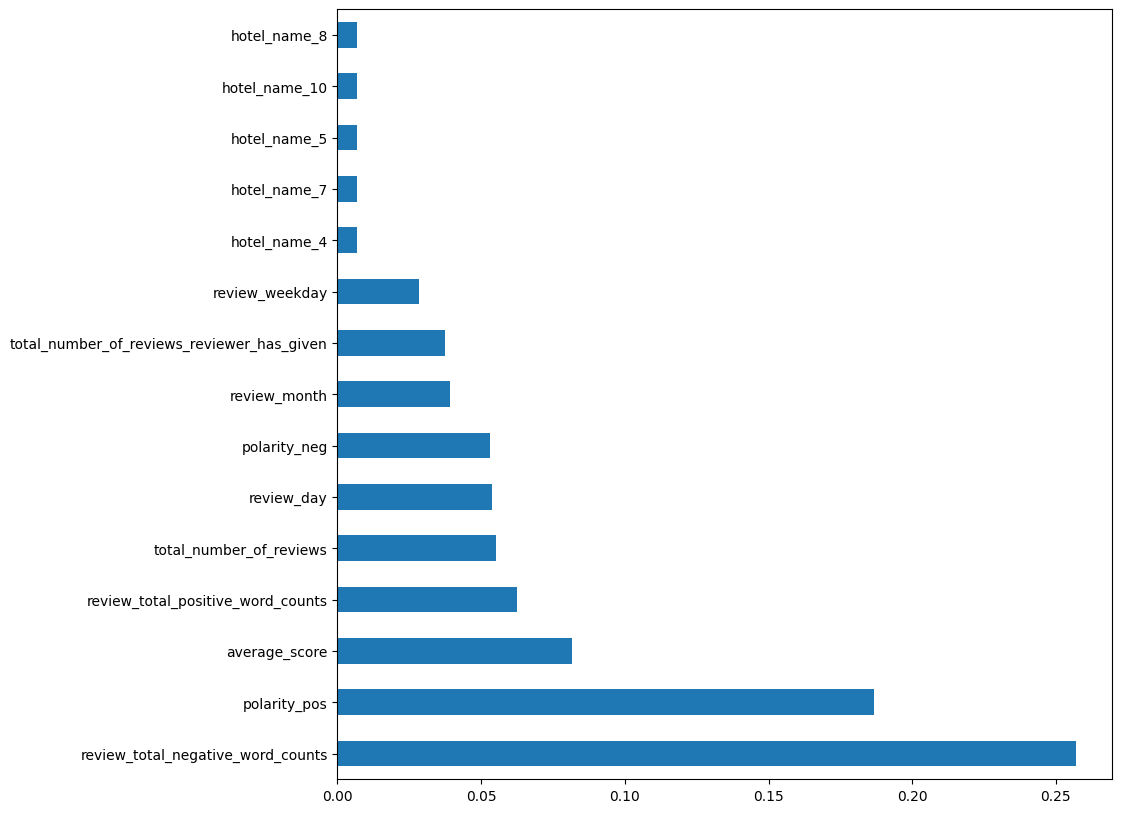

In [ ]:
# выведем самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_pred = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   52.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  2.1min finished
